In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score as cv_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# Regression models based on all common experiment factors

In [ ]:
df = pd.read_csv(
    "../clean/cleaned_data/dominant_color_modeling_data.csv"
)

X = df.drop(["Timestamp", "chl"], axis=1)
y = df["chl"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

# For statsmodels
x = sm.add_constant(X)

In [ ]:
y_std_lt2 = np.std(y.where(y < 2))
y_std_gte2 = np.std(y.where(y >= 2))
y_std = np.std(y)
print(f"std. dev {y_std:.3f}")
print(f"lt 2     {y_std_lt2:.3f}")
print(f"gte 2    {y_std_gte2:.3f}")

std. dev 1.223
lt 2     0.238
gte 2    2.084


## Ordinary Least Squares

In [ ]:
ols_model = lm.LinearRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ols_mae = np.absolute(cv_score(
    ols_model, 
    X, 
    y, 
    scoring = "neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1
    ))
ols_mean_mae = np.mean(ols_mae)

In [ ]:
print(f"Mean OLS MAE for CV:\t{ols_mean_mae:.3f}")

Mean OLS MAE for CV:	0.422


In [ ]:
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    chl   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     104.8
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          4.14e-236
Time:                        02:31:58   Log-Likelihood:                -1331.1
No. Observations:                1186   AIC:                             2702.
Df Residuals:                    1166   BIC:                             2804.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Lasso - Lambda selection

In [ ]:
lasso_model = lm.Lasso()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Find best lambda
lasso_grid = {}
lasso_grid["alpha"] = np.logspace(-3., 7., num=1_000)
lasso_search = GridSearchCV(
    lasso_model, 
    lasso_grid, 
    scoring="neg_mean_absolute_error", 
    cv=cv, 
    n_jobs=-1
    )
lasso_results = lasso_search.fit(X, y)
lasso_mae = np.absolute(lasso_results.best_score_)
lasso_alpha = lasso_results.best_params_

In [ ]:
print(f"Lasso MAE:\t{lasso_mae:.3f}")
print(f"Lambda:\t\t{lasso_alpha['alpha']:.3f}")

Lasso MAE:	0.409
Lambda:		1.239


In [ ]:
lasso_results = model.fit_regularized(alpha=lasso_alpha['alpha'], start_params=results.params, refit=True)
lasso_summary = lasso_results.summary()
print(lasso_summary)

                            OLS Regression Results                            
Dep. Variable:                    chl   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     296.9
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          1.13e-231
Time:                        02:36:42   Log-Likelihood:                -1376.1
No. Observations:                1186   AIC:                             2766.
Df Residuals:                    1180   BIC:                             2802.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Ridge - Lambda selection

In [ ]:
ridge_model = lm.Ridge()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Find best lambda
ridge_grid = {}
ridge_grid["alpha"] = np.logspace(-3., 7., num=1_000)
ridge_search = GridSearchCV(
    ridge_model, 
    ridge_grid, 
    scoring="neg_mean_absolute_error", 
    cv=cv, 
    n_jobs=-1
    )
ridge_results = ridge_search.fit(X, y)
ridge_mae = np.absolute(ridge_results.best_score_)
ridge_alpha = ridge_results.best_params_

In [ ]:
print(f"Ridge MAE:\t{ridge_mae:.3f}")
print(f"Lambda:\t\t{ridge_alpha['alpha']:.3f}")

Ridge MAE:	0.411
Lambda:		1306.520


In [ ]:
ridge_results = model.fit_regularized(L1_wt=0.00000000000001, alpha=ridge_alpha['alpha'], start_params=results.params, refit=True)
print(ridge_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    chl   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     104.7
Date:                Wed, 26 Apr 2023   Prob (F-statistic):          4.46e-236
Time:                        02:39:31   Log-Likelihood:                -1331.7
No. Observations:                1186   AIC:                             2703.
Df Residuals:                    1167   BIC:                             2805.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

## Train and Test

In [ ]:
ols_model = ols_model.fit(X_train, y_train)
ridge_best_model = lm.Ridge(alpha=ridge_alpha['alpha']).fit(X_train, y_train)
lasso_best_model = lm.Lasso(alpha=lasso_alpha['alpha']).fit(X_train, y_train)

import joblib


ols_pred = ols_model.predict(X_test)
ridge_pred = ridge_best_model.predict(X_test)
lasso_pred = lasso_best_model.predict(X_test)

In [ ]:
models = list(zip(
        [ols_pred, ridge_pred, lasso_pred], 
        ["OLS", "Ridge", "Lasso"]
))

model_mae = {
    method: mean_absolute_error(y_test, pred)
    for pred, method in models
}

model_rmse = {
    method: mean_squared_error(y_test, pred, squared=False)
    for pred, method in models
}

model_r2 = {
    method: r2_score(y_test, pred)
    for pred, method in models
}

model_metrics = {
    method: [
        model_mae[method],
        model_rmse[method],
        model_r2[method]
    ]
    for method in ["OLS", "Ridge", "Lasso"]
}

In [ ]:
performance_metrics = pd.DataFrame.from_dict(
    model_metrics,
    orient="index",
    columns = ["Test_MAE", "Test_RMSE", "Test_R2"]
)
performance_metrics.round(3)

,Test_MAE,Test_RMSE,Test_R2
OLS,0.403,0.671,0.685
Ridge,0.399,0.680,0.677
Lasso,0.402,0.696,0.662


<ipython-input-17-dca2050ce2e6>:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


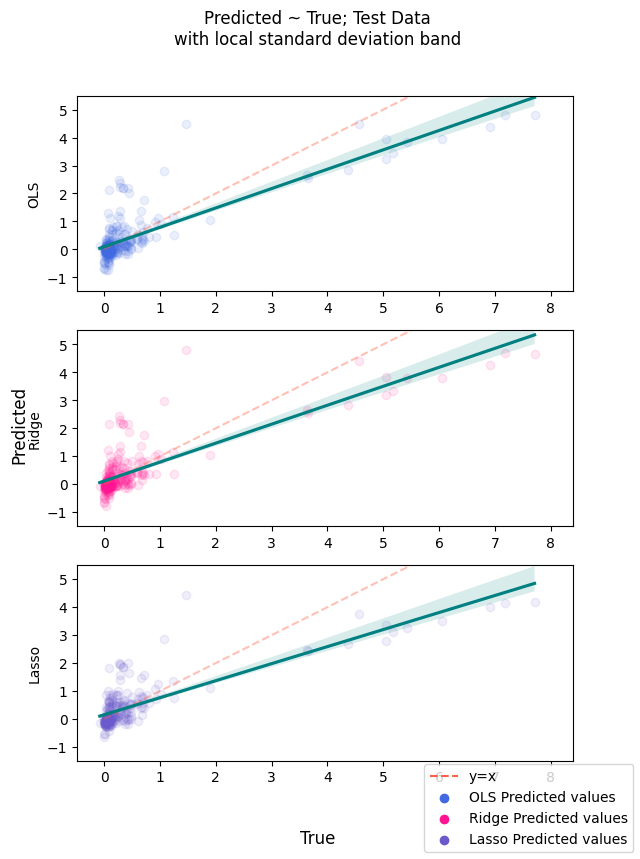

In [ ]:
from seaborn import regplot

fig, axes = plt.subplots(3)
fig.suptitle("Predicted ~ True; Test Data\nwith local standard deviation band", )
fig.supxlabel("True")
fig.supylabel("Predicted")
size = fig.get_size_inches()
sizex = 1*size[0]
sizey = 1.8*size[1]
fig.set_size_inches(sizex, sizey)
label = "y=x"

for ax, model, c in zip(axes, models, ["royalblue", "deeppink", "slateblue"]):
  if c == "deeppink":
    label = ""
  ax.plot(range(9), linestyle='--', c='tomato', alpha=0.4, label=label, )
  regplot(
    x=y_test, 
    y=model[0],
    ax=ax,
    x_ci="sd",
    label=f"{model[1]} Predicted values", 
    color="teal", 
    scatter_kws={"alpha": 0.1, "color": c}
  )
  ax.set(ylabel=model[1])
  ax.set(xlabel=None)
  ax.set_ylim([-1.5,5.5])
  
  
leg = fig.legend(loc="lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1);
plt.savefig("./plots/dom_col_pred_vs_true_test_data.png")

In [ ]:
train_ols_pred = ols_model.predict(X_train)
train_ridge_pred = ridge_best_model.predict(X_train)
train_lasso_pred = lasso_best_model.predict(X_train)

In [ ]:
train_models = list(zip(
        [train_ols_pred, train_ridge_pred, train_lasso_pred], 
        ["OLS", "Ridge", "Lasso"]
))

train_model_mae = {
    method: mean_absolute_error(y_train, pred)
    for pred, method in train_models
}

train_model_rmse = {
    method: mean_squared_error(y_train, pred, squared=False)
    for pred, method in train_models
}

train_model_r2 = {
    method: r2_score(y_train, pred)
    for pred, method in train_models
}

train_model_metrics = {
    method: [
        train_model_mae[method],
        train_model_rmse[method],
        train_model_r2[method]
    ]
    for method in ["OLS", "Ridge", "Lasso"]
}

In [ ]:
train_performance_metrics = pd.DataFrame.from_dict(
    train_model_metrics,
    orient="index",
    columns = ["Train_MAE", "Train_RMSE", "Train_R2"]
)
train_performance_metrics.round(3)

,Train_MAE,Train_RMSE,Train_R2
OLS,0.416,0.764,0.614
Ridge,0.411,0.770,0.608
Lasso,0.413,0.802,0.575


<ipython-input-21-a85ef31f7625>:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


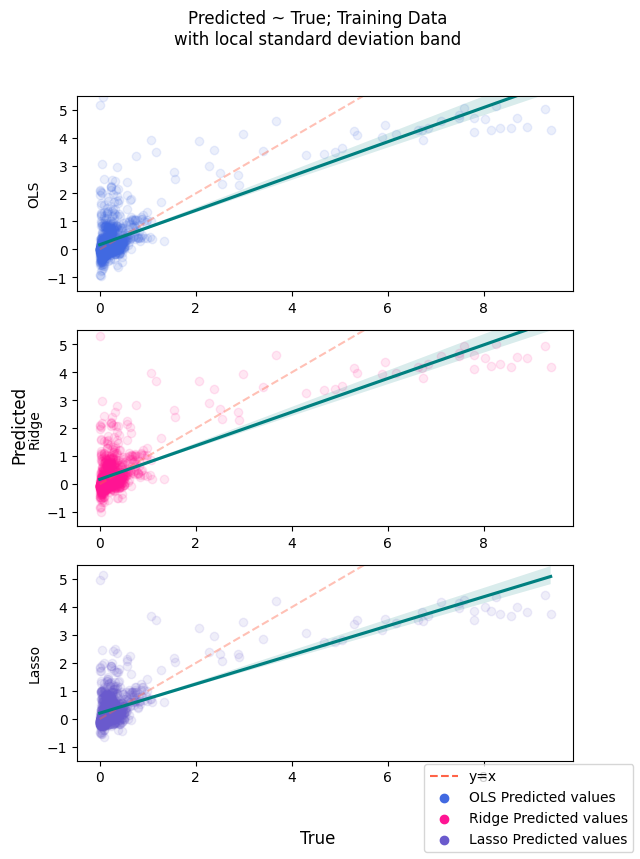

In [ ]:
fig, axes = plt.subplots(3)
fig.suptitle("Predicted ~ True; Training Data\nwith local standard deviation band", )
fig.supxlabel("True")
fig.supylabel("Predicted")
size = fig.get_size_inches()
sizex = 1*size[0]
sizey = 1.8*size[1]
fig.set_size_inches(sizex, sizey)
label = "y=x"

for ax, model, c in zip(axes, train_models, ["royalblue", "deeppink", "slateblue"]):
  if c == "deeppink":
    label = ""
  ax.plot(range(9), linestyle='--', c='tomato', alpha=0.4, label=label, )
  regplot(
    x=y_train, 
    y=model[0],
    ax=ax,
    x_ci="sd",
    label=f"{model[1]} Predicted values", 
    color="teal", 
    scatter_kws={"alpha": 0.1, "color": c}
  )
  ax.set(ylabel=model[1])
  ax.set(xlabel=None)
  ax.set_ylim([-1.5,5.5])
  
  
leg = fig.legend(loc="lower right")
for lh in leg.legendHandles: 
    lh.set_alpha(1);
plt.savefig("./plots/dom_col_pred_vs_true_training_data.png")

### Indices of predictors eliminated by Lasso

In [ ]:
rejected_predictors_i = list(set([
    i 
    for i, rows in enumerate(lasso_summary.tables[1].data[2:]) 
    for row in rows 
    if "nan" in row
]))

lasso_predictors = [
    X.columns[i] 
    for i in range(len(X.columns)) 
    if i not in rejected_predictors_i
]

## Models Trained with Best Subset Feature Selection
Select best subset of feautures based on MAE

In [ ]:
# import joblib
# import sys
# sys.modules['sklearn.externals.joblib'] = joblib
# import mlxtend.feature_selection as feat_select

# rgb = [
#     X.columns.get_loc(c) 
#     for c in ["r1", "g1", "b1"] 
#     if c in X
# ]
# other_features = [
#     [X.columns.get_loc(c)]
#     for c in list(X.columns)
#     if c not in ["r1", "g1", "b1"]
# ]

# cv_bss = cv = RepeatedKFold(n_splits=8, n_repeats=2, random_state=1)

# EFS = feat_select.ExhaustiveFeatureSelector
# efs = EFS(
#     lm.LinearRegression(),
#     min_features=3,
#     max_features=8,
#     scoring='neg_mean_absolute_error',
#     cv=cv,
#     fixed_features=rgb,
#     feature_groups=[rgb] + other_features,
#     n_jobs=-1
# )

# fit = efs.fit(X_train, y_train)

Features: 26316/26316

In [ ]:
# print(f"Best MAE: \t\t{-1*fit.best_score_}")
# print(f"Feature indicies: \t{fit.best_idx_}")
# print(f"Best features: \t\t{fit.best_feature_names_}")
# print(f"Lasso predictors: \t{lasso_predictors}")

Best MAE: 		0.4079559010452182
Feature indicies: 	(0, 1, 3, 8, 12, 13, 14, 15)
Best features: 		('temp_25dm', 'temp_75dm', 'PAR_5dm', 'temp_10m', 'r1', 'g1', 'b1', 'r2')
Lasso predictors: 	['temp_25dm', 'temp_75dm', 'temp_5m', 'PAR_1m', 'pressure_db_20m', 'longitude', 'latitude', 'r1', 'g1', 'b1', 'r2']


The Best Subset Selection model is very similar to the Lasso selected model. The key features are temperature, surface light, the RGB channels of the dominant image color, and the red channel of the secondary image color.